
# 2. EDA 

This notebook expects the following files in the working directory:

- `cleaned_EDA_ready_timeseries.csv` — the cleaned, merged dataset (one row per country-year)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
# Load
df = pd.read_csv("cleaned_EDA_ready_timeseries.csv")
print("Shape:", df.shape)
display(df)

Shape: (7830, 14)


,Country Name,Country Code,Year,GDP_current_usd,Population_total,LifeExp_years,Energy_use_kg_oil_pc,Renewable_energy_pct,CO2_total_mt,CO2_per_capita_ton,log1p_GDP_current_usd,log1p_Population_total,log1p_Energy_use_kg_oil_pc,log1p_CO2_total_mt
0,Albania,ALB,1970,1.578102e+09,2135479.0,65.234,813.373801,25.5,4.8450,2.268812,21.179489,14.574202,6.702419,1.765587
1,Albania,ALB,1971,1.578102e+09,2187853.0,65.896,813.373801,25.5,4.8381,2.211346,21.179489,14.598432,6.702419,1.764405
2,Albania,ALB,1972,1.578102e+09,2243126.0,66.526,813.373801,25.5,5.5183,2.460094,21.179489,14.623381,6.702419,1.874614
3,Albania,ALB,1973,1.578102e+09,2296752.0,67.107,813.373801,25.5,4.9519,2.156045,21.179489,14.647007,6.702419,1.783710
4,Albania,ALB,1974,1.578102e+09,2350124.0,67.633,813.373801,25.5,5.3296,2.267795,21.179489,14.669979,6.702419,1.845237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7825,Zimbabwe,ZWE,2019,2.571566e+10,15271368.0,61.060,412.165419,81.0,11.1692,0.731382,23.970366,16.541490,6.023848,2.498908
7826,Zimbabwe,ZWE,2020,2.686856e+10,15526888.0,61.530,373.557246,84.1,9.0721,0.584283,24.014223,16.558084,5.925745,2.309769
7827,Zimbabwe,ZWE,2021,2.724051e+10,15797210.0,60.135,405.518564,82.4,10.6233,0.672480,24.027971,16.575344,6.007630,2.453012
7828,Zimbabwe,ZWE,2022,3.278966e+10,16069056.0,62.360,416.586875,82.4,10.9630,0.682243,24.213379,16.592406,6.034493,2.481819


## 1) Global Trends

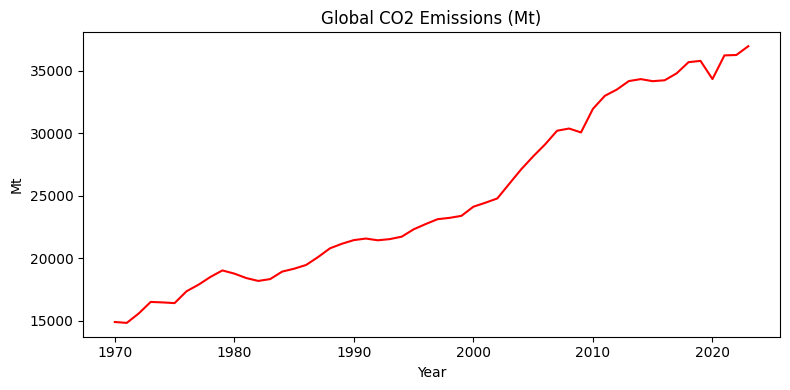

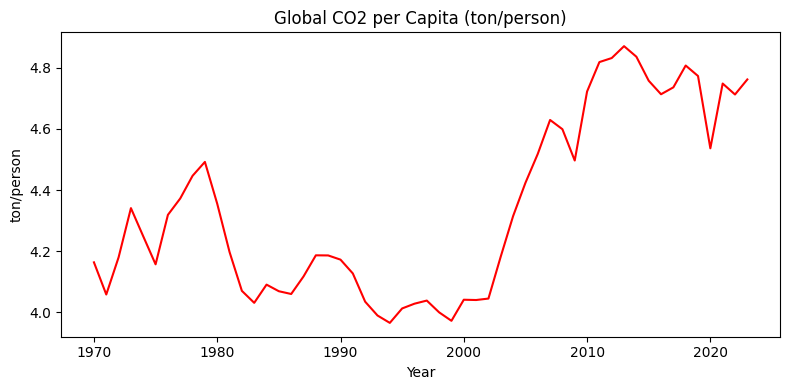

In [2]:

# Global CO2 (Mt)
global_co2 = df.groupby("Year")["CO2_total_mt"].sum()
plt.figure(figsize=(8,4))
plt.plot(global_co2.index, global_co2.values,color='red')
plt.title("Global CO2 Emissions (Mt)")
plt.xlabel("Year"); plt.ylabel("Mt")
plt.tight_layout(); plt.show()

# Global CO2 per capita (ton/person)
yearly = df.groupby("Year").agg(
    CO2_total_mt=("CO2_total_mt", "sum"),
    Population_total=("Population_total", "sum"))

global_co2_pc = (yearly["CO2_total_mt"]*1e6) / yearly["Population_total"]

plt.figure(figsize=(8,4))
plt.plot(global_co2_pc.index, global_co2_pc.values,color='red')
plt.title("Global CO2 per Capita (ton/person)")
plt.xlabel("Year"); plt.ylabel("ton/person")
plt.tight_layout(); plt.show()


## 2) Per-Country Trends (Top Emitters & per-capita)

In [3]:
df_recent = df[df["Year"].between(2018, 2022)]
co2_mean = df_recent.groupby("Country Name")["CO2_total_mt"].mean().sort_values(ascending=False)

In [4]:
q1 = co2_mean.quantile(1/3)
q2 = co2_mean.quantile(2/3)

def categorize_emitter(value):
    if value >= q2:
        return "High"
    elif value >= q1:
        return "Medium"
    else:
        return "Low"

tier_map = co2_mean.apply(categorize_emitter).to_dict()
df["Emission_Tier"] = df["Country Name"].map(tier_map)

In [5]:
df.groupby("Emission_Tier")["Country Name"].nunique()

Emission_Tier
High      48
Low       50
Medium    47
Name: Country Name, dtype: int64

<Axes: xlabel='Year', ylabel='CO2_total_mt'>

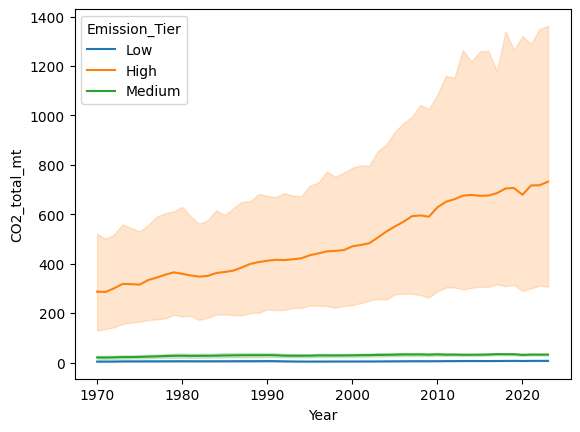

In [7]:
sns.lineplot(data=df, x="Year", y="CO2_total_mt", hue="Emission_Tier")

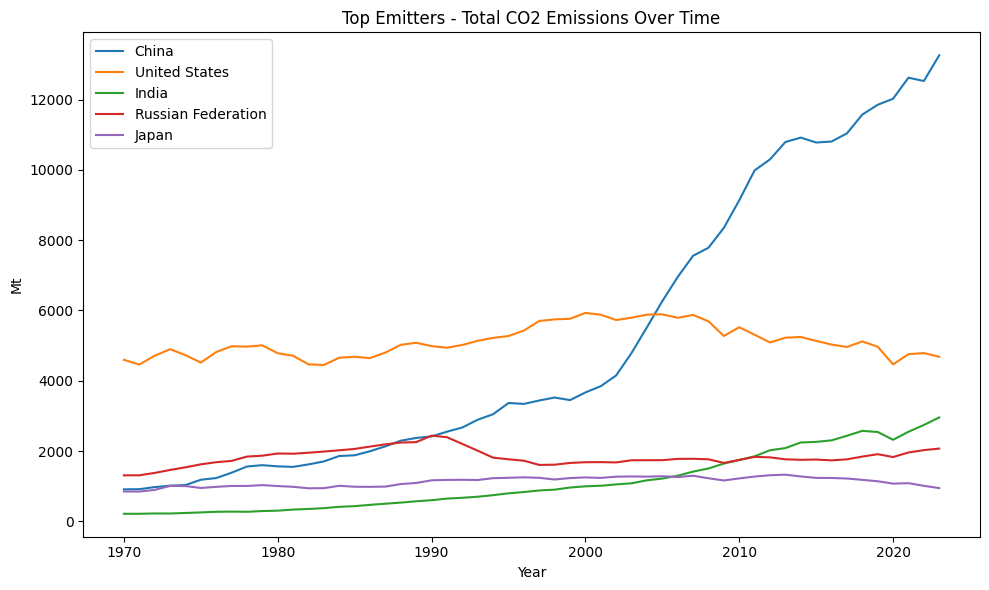

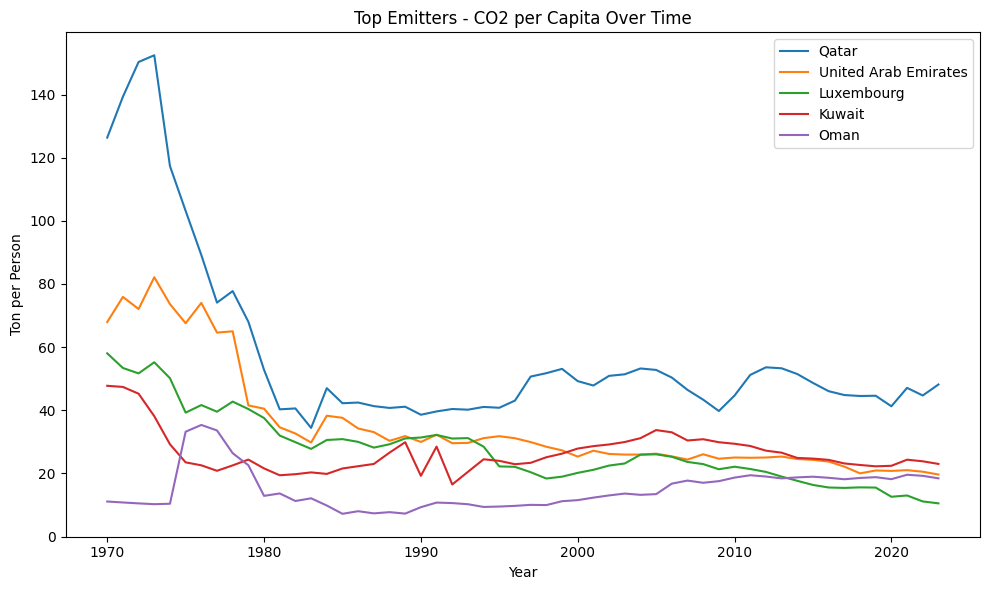

In [3]:
# Top 5 by total emissions
top_emitters_total = (
    df.groupby("Country Name")["CO2_total_mt"].max()
      .sort_values(ascending=False).head(5).index)

# Top 5 by per capita emissions
top_emitters_percap = (
    df.groupby("Country Name")["CO2_per_capita_ton"].max()
      .sort_values(ascending=False).head(5).index)

# Plot total CO2
plt.figure(figsize=(10,6))
for c in top_emitters_total:
    tmp = df[df["Country Name"]==c].groupby("Year")["CO2_total_mt"].mean()
    plt.plot(tmp.index, tmp.values, label=c)
plt.title("Top Emitters - Total CO2 Emissions Over Time")
plt.xlabel("Year"); plt.ylabel("Mt")
plt.legend(); plt.tight_layout(); plt.show()

# Plot per capita CO2
plt.figure(figsize=(10,6))
for c in top_emitters_percap:
    tmp = df[df["Country Name"]==c].groupby("Year")["CO2_per_capita_ton"].mean()
    plt.plot(tmp.index, tmp.values, label=c)
plt.title("Top Emitters - CO2 per Capita Over Time")
plt.xlabel("Year"); plt.ylabel("Ton per Person")
plt.legend(); plt.tight_layout(); plt.show()

## 3) Distributions

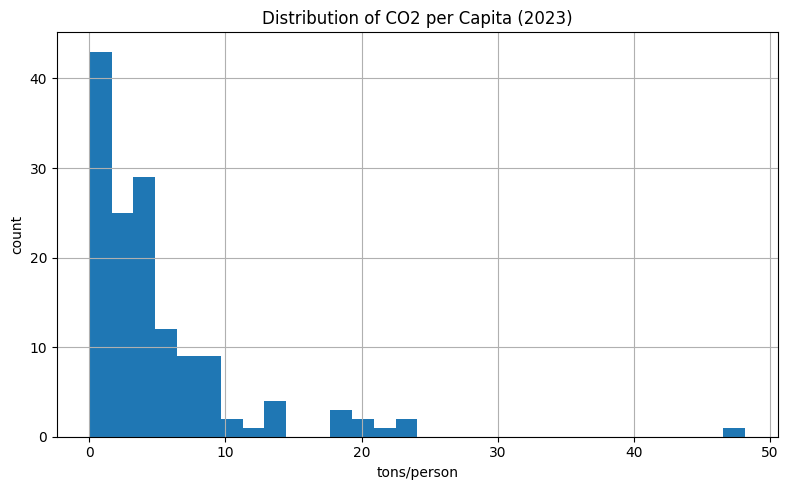

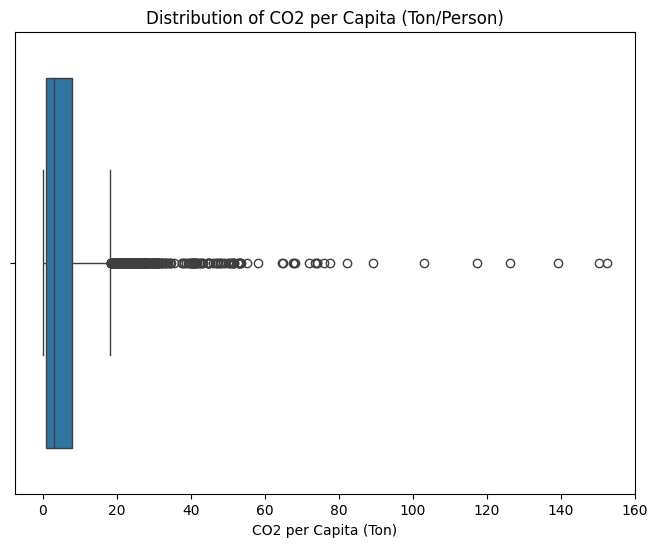

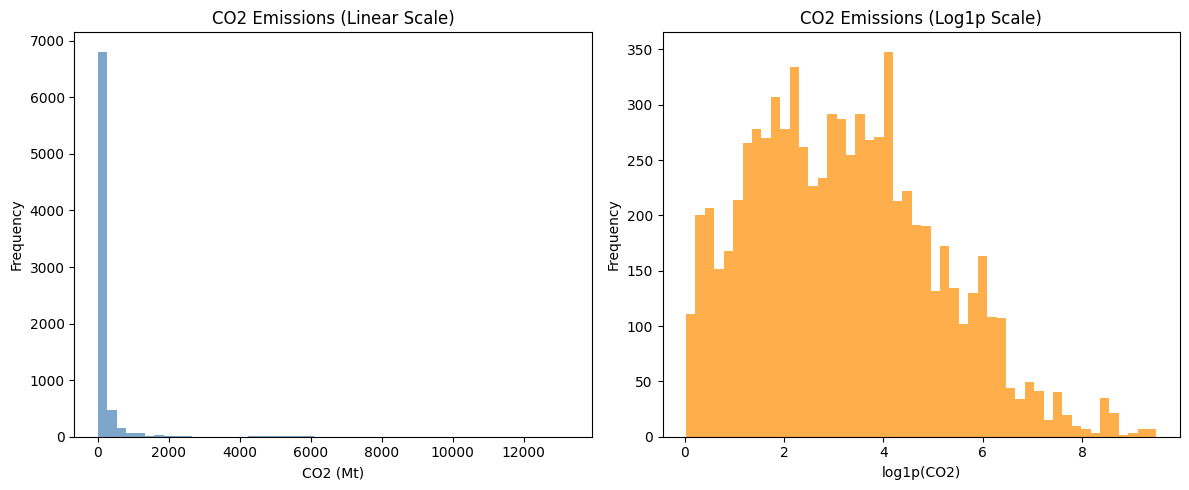

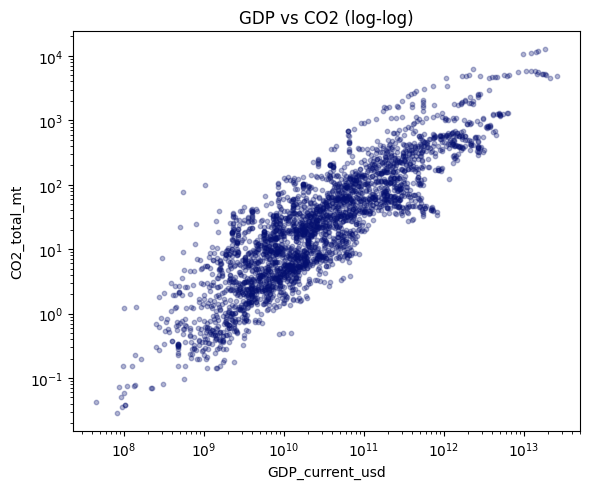

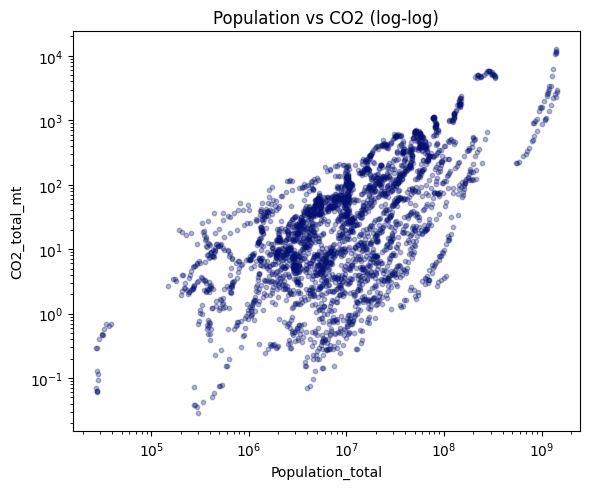

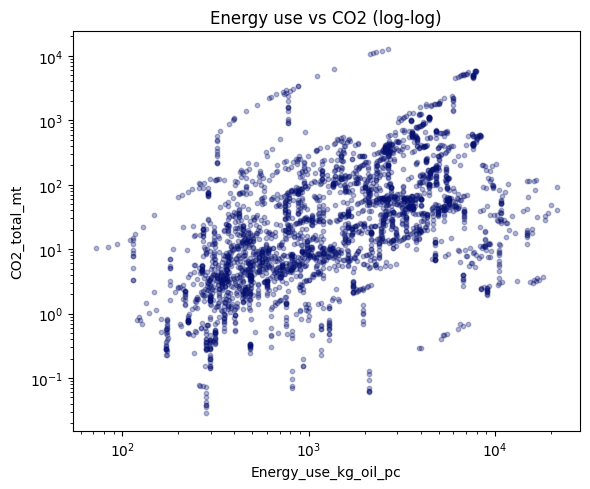

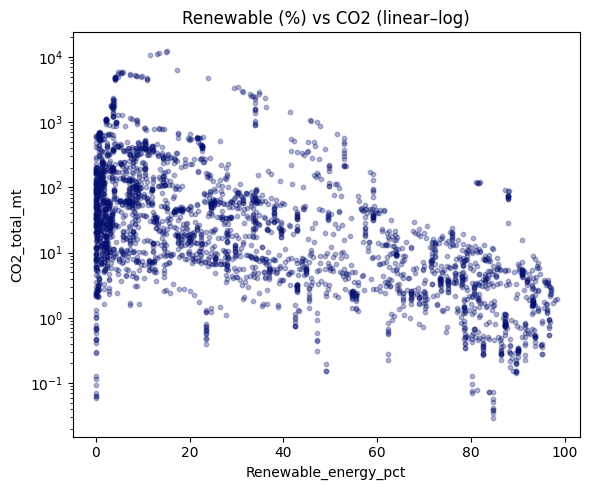

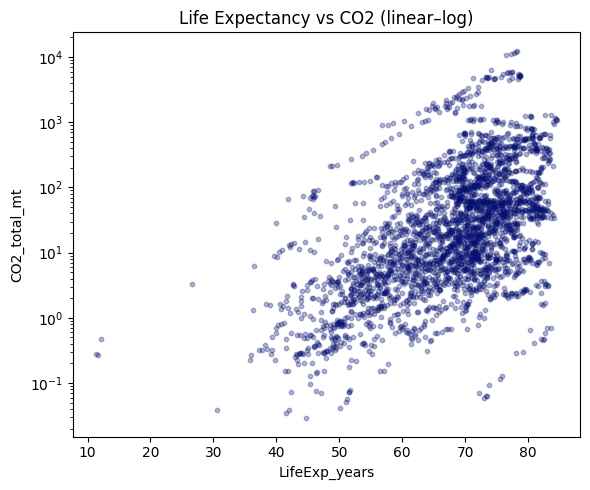

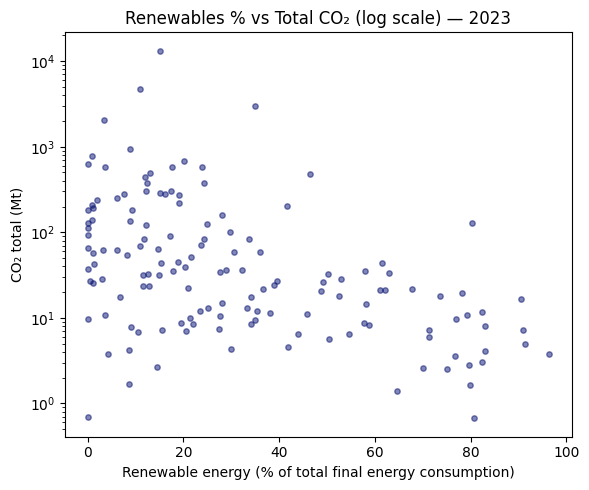

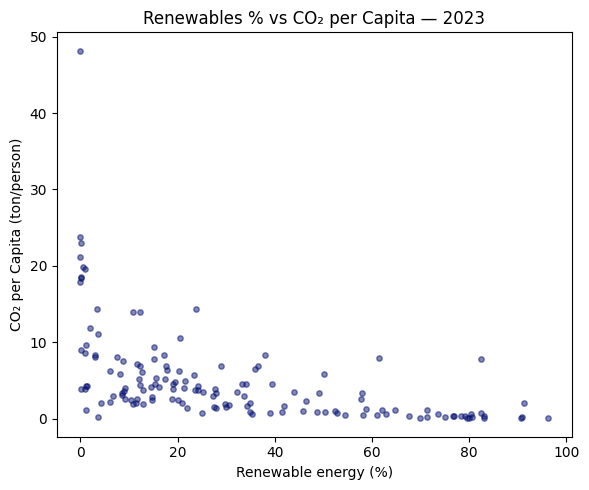

In [4]:
latest_year = int(df["Year"].max())

# Distribution of CO2 per capita (latest year)
plt.figure(figsize=(8,5))
df[df["Year"]==latest_year]["CO2_per_capita_ton"].dropna().hist(bins=30)
plt.title(f"Distribution of CO2 per Capita ({latest_year})")
plt.xlabel("tons/person"); plt.ylabel("count")
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x=df["CO2_per_capita_ton"])
plt.title("Distribution of CO2 per Capita (Ton/Person)")
plt.xlabel("CO2 per Capita (Ton)")
plt.show()

# Histogram (linear scale)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(df["CO2_total_mt"], bins=50, color="steelblue", alpha=0.7)
plt.title("CO2 Emissions (Linear Scale)")
plt.xlabel("CO2 (Mt)")
plt.ylabel("Frequency")

# Histogram (log1p scale)
plt.subplot(1,2,2)
plt.hist(np.log1p(df["CO2_total_mt"]), bins=50, color="darkorange", alpha=0.7)
plt.title("CO2 Emissions (Log1p Scale)")
plt.xlabel("log1p(CO2)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Scatterplots
def _scatter(x, y, logx=False, logy=False, sample=3000, title=None):
    data = df[[x,y]].replace([np.inf,-np.inf], np.nan).dropna()
    if len(data) > sample:
        data = data.sample(sample, random_state=42)
    plt.figure(figsize=(6,5))
    plt.scatter(data[x], data[y], alpha=0.3, s=10,color="#051070")
    if logx: plt.xscale("log")
    if logy: plt.yscale("log")
    plt.xlabel(x); plt.ylabel(y); plt.title(title or f"{x} vs {y}"); plt.tight_layout(); plt.show()

_scatter("GDP_current_usd","CO2_total_mt", logx=True, logy=True, title="GDP vs CO2 (log-log)")
_scatter("Population_total","CO2_total_mt", logx=True, logy=True, title="Population vs CO2 (log-log)")
_scatter("Energy_use_kg_oil_pc","CO2_total_mt", logx=True, logy=True, title="Energy use vs CO2 (log-log)")
_scatter("Renewable_energy_pct","CO2_total_mt", logy=True, title="Renewable (%) vs CO2 (linear–log)")
_scatter("LifeExp_years", "CO2_total_mt", logy=True, title="Life Expectancy vs CO2 (linear–log)")

# Renewables vs CO₂ (Total & Per Capita)
d_latest = df[df["Year"] == latest_year][["Country Name","Renewable_energy_pct","CO2_total_mt"]].dropna()
plt.figure(figsize=(6,5))
plt.scatter(d_latest["Renewable_energy_pct"], d_latest["CO2_total_mt"], alpha=0.5, s=15,color="#051070")
plt.yscale("log")
plt.title(f"Renewables % vs Total CO₂ (log scale) — {latest_year}")
plt.xlabel("Renewable energy (% of total final energy consumption)")
plt.ylabel("CO₂ total (Mt)")
plt.tight_layout(); plt.show()

if "CO2_per_capita_ton" in df.columns:
    d_latest2 = df[df["Year"] == latest_year][["Country Name","Renewable_energy_pct","CO2_per_capita_ton"]].dropna()
    plt.figure(figsize=(6,5))
    plt.scatter(d_latest2["Renewable_energy_pct"], d_latest2["CO2_per_capita_ton"], alpha=0.5, s=15,color="#051070")
    plt.title(f"Renewables % vs CO₂ per Capita — {latest_year}")
    plt.xlabel("Renewable energy (%)")
    plt.ylabel("CO₂ per Capita (ton/person)")
    plt.tight_layout(); plt.show()

## 4) Rankings

In [5]:
# Top emitters in the latest year
ranking = df[df["Year"]==latest_year].sort_values("CO2_total_mt", ascending=False).head(10)
ranking_display = ranking[["Country Name","CO2_total_mt","CO2_per_capita_ton","Renewable_energy_pct"]].reset_index(drop=True)
display(ranking_display)

,Country Name,CO2_total_mt,CO2_per_capita_ton,Renewable_energy_pct
0,China,13259.6390,9.399266,15.2
1,United States,4682.0394,13.901285,10.9
2,India,2955.1817,2.054964,34.9
3,Russian Federation,2069.5020,14.388915,3.5
4,Japan,944.7586,7.587408,8.8
5,"Iran, Islamic Rep.",778.8023,8.595226,0.9
6,Indonesia,674.5359,2.398861,20.2
7,Saudi Arabia,622.9136,18.482585,0.1
8,Germany,582.9506,6.948000,17.6
9,Canada,575.0120,14.345360,23.8


## 5) Trend Slopes per Country

In [6]:
# Linear regression slope of CO2_total_mt vs Year per country
slopes = {}
for c, g in df.groupby("Country Name"):
    g2 = g.dropna(subset=["CO2_total_mt"])
    if len(g2) > 10:
        X = g2[["Year"]]
        y = g2["CO2_total_mt"]
        model = LinearRegression().fit(X, y)
        slopes[c] = float(model.coef_[0])   # slope

slopes_series = pd.Series(slopes).sort_values(ascending=False)
top_increase = slopes_series.head(10)
top_decrease = slopes_series.tail(10)
print("Top 10 countries CO2 increasing fastest")
display(top_increase.to_frame("slope"))
print("Top 10 countries CO2 decreasing fastest")
display(top_decrease.to_frame("slope"))

Top 10 countries CO2 increasing fastest


,slope
China,244.427415
India,50.295509
"Iran, Islamic Rep.",13.746149
"Korea, Rep.",13.035437
Indonesia,12.339502
Saudi Arabia,11.246130
United States,11.006697
Brazil,8.014917
Turkiye,7.875920
Mexico,7.373266


Top 10 countries CO2 decreasing fastest


,slope
Bulgaria,-0.924075
Sweden,-0.960392
"Korea, Dem. People's Rep.",-1.185617
Czechia,-2.109237
Poland,-2.185302
Romania,-2.408200
France,-3.512784
United Kingdom,-5.689091
Germany,-9.452011
Ukraine,-9.809986


## 6) Relationships Over Time

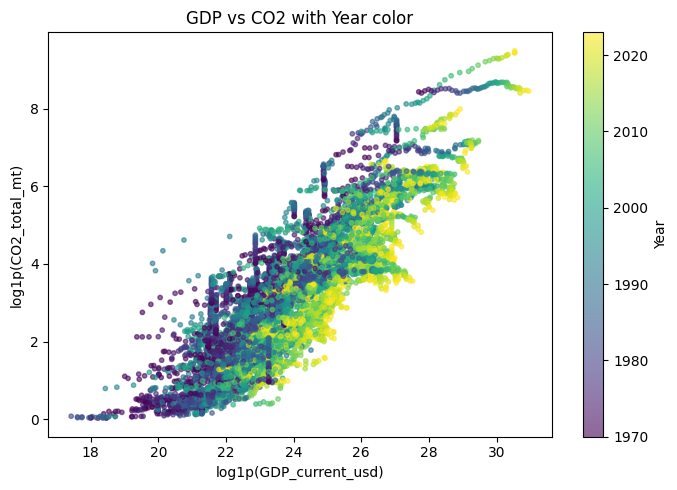

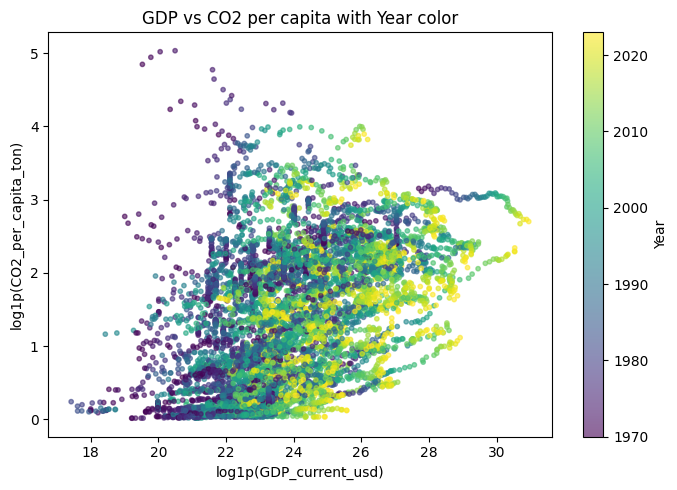

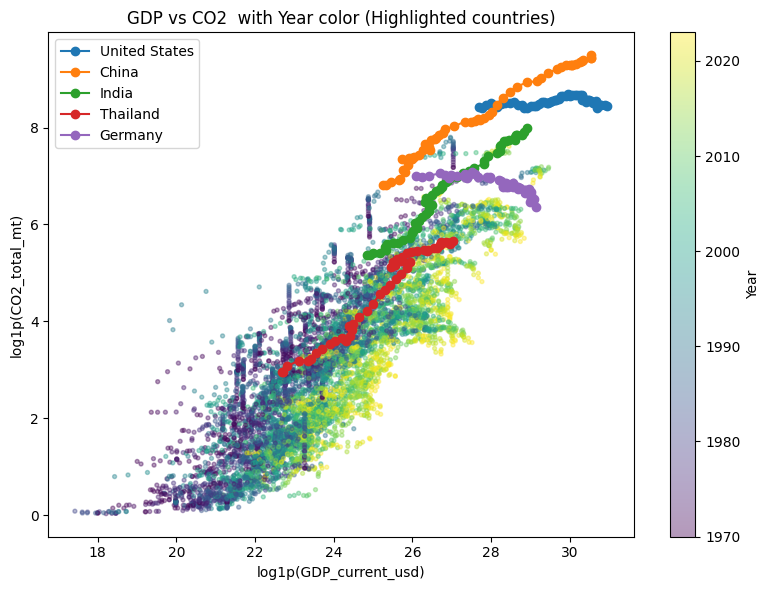

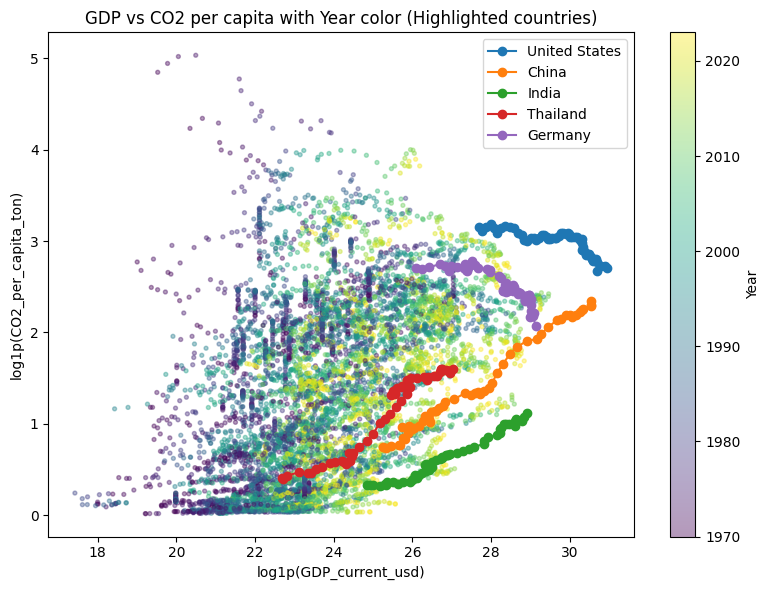

In [7]:
# gdp vs total emissions
plt.figure(figsize=(7,5))
plt.scatter(np.log1p(df["GDP_current_usd"]), np.log1p(df["CO2_total_mt"]),
            c=df["Year"], s=10, alpha=0.6)
plt.colorbar(label="Year")
plt.xlabel("log1p(GDP_current_usd)")
plt.ylabel("log1p(CO2_total_mt)")
plt.title("GDP vs CO2 with Year color")
plt.tight_layout(); plt.show()


# gdp vs per capita
if "CO2_per_capita_ton" not in df.columns:
    df["CO2_per_capita_ton"] = (df["CO2_total_mt"] * 1e6) / df["Population_total"]

plt.figure(figsize=(7,5))
plt.scatter(
    np.log1p(df["GDP_current_usd"]), 
    np.log1p(df["CO2_per_capita_ton"]), 
    c=df["Year"], s=10, alpha=0.6)
plt.colorbar(label="Year")
plt.xlabel("log1p(GDP_current_usd)")
plt.ylabel("log1p(CO2_per_capita_ton)")
plt.title("GDP vs CO2 per capita with Year color")
plt.tight_layout(); plt.show()

# highlight chosen countries
highlight_countries = ["United States", "China", "India", "Thailand", "Germany"]
# # gdp vs total emissions
plt.figure(figsize=(8,6))
sc2 = plt.scatter(np.log1p(df["GDP_current_usd"]), 
                 np.log1p(df["CO2_total_mt"]), 
                 c=df["Year"], s=8, alpha=0.4, cmap="viridis")

for country in highlight_countries:
    tmp = df[df["Country Name"] == country]
    plt.plot(np.log1p(tmp["GDP_current_usd"]), 
             np.log1p(tmp["CO2_total_mt"]),
             marker="o", linestyle="-", label=country)

plt.colorbar(sc2, label="Year")
plt.xlabel("log1p(GDP_current_usd)")
plt.ylabel("log1p(CO2_total_mt)")
plt.title("GDP vs CO2  with Year color (Highlighted countries)")
plt.legend()
plt.tight_layout()
plt.show()

# gdp vs per capita
plt.figure(figsize=(8,6))
sc = plt.scatter(np.log1p(df["GDP_current_usd"]), 
                 np.log1p(df["CO2_per_capita_ton"]), 
                 c=df["Year"], s=8, alpha=0.4, cmap="viridis")

for country in highlight_countries:
    tmp = df[df["Country Name"] == country]
    plt.plot(np.log1p(tmp["GDP_current_usd"]), 
             np.log1p(tmp["CO2_per_capita_ton"]),
             marker="o", linestyle="-", label=country)

plt.colorbar(sc, label="Year")
plt.xlabel("log1p(GDP_current_usd)")
plt.ylabel("log1p(CO2_per_capita_ton)")
plt.title("GDP vs CO2 per capita with Year color (Highlighted countries)")
plt.legend()
plt.tight_layout()
plt.show()

## 7) Correlation Heatmap

In [9]:
df.columns

Index(['Country Name', 'Country Code', 'Year', 'GDP_current_usd',
       'Population_total', 'LifeExp_years', 'Energy_use_kg_oil_pc',
       'Renewable_energy_pct', 'CO2_total_mt', 'CO2_per_capita_ton',
       'log1p_GDP_current_usd', 'log1p_Population_total',
       'log1p_Energy_use_kg_oil_pc', 'log1p_CO2_total_mt', 'Emission_Tier'],
      dtype='object')

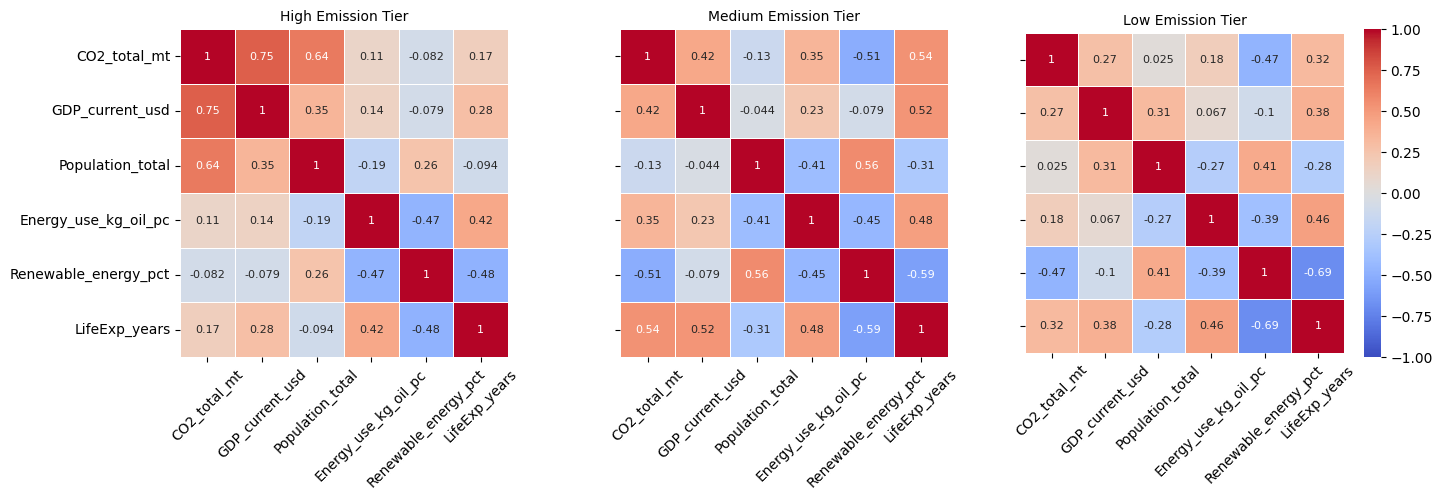

In [ ]:
features = [
    "CO2_total_mt",
    "GDP_current_usd",
    "Population_total",
    "Energy_use_kg_oil_pc",
    "Renewable_energy_pct",
    "LifeExp_years"
]

tiers = ["High", "Medium", "Low"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

for ax, tier in zip(axes, tiers):
    df_tier = df[df["Emission_Tier"] == tier]
    corr = df_tier[features].corr()
    sns.heatmap(
        corr, ax=ax, annot=True, cmap="coolwarm",
        vmin=-1, vmax=1, cbar=(tier=="Low"), 
        square=True, linewidths=0.5, annot_kws={"size":8}
    )
    ax.set_title(f"{tier} Emission Tier", fontsize=10)
    ax.tick_params(axis="x", labelrotation=45)
    ax.tick_params(axis="y", rotation=0)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


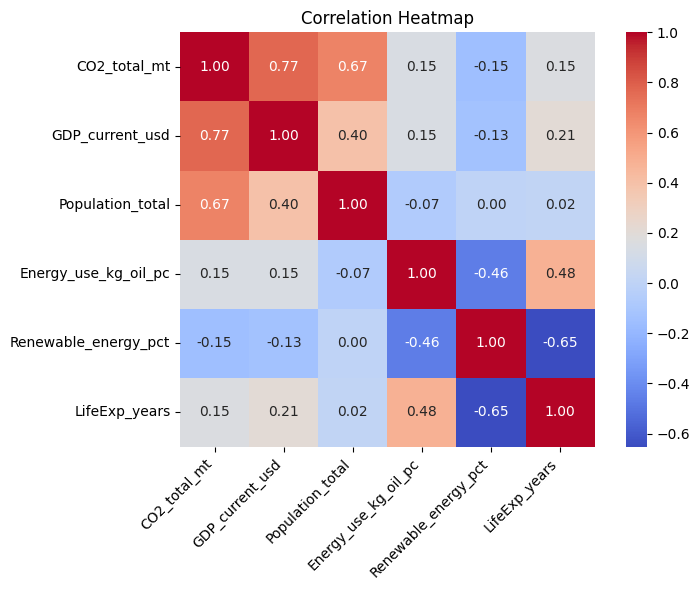

In [8]:
corr_cols = ["CO2_total_mt","GDP_current_usd","Population_total","Energy_use_kg_oil_pc","Renewable_energy_pct","LifeExp_years"]
corr = df[corr_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.xticks(rotation=45, ha="right")
plt.title("Correlation Heatmap"); plt.tight_layout(); plt.show()